# MEV Analysis
*load environment*

In [1]:
exec(open('load.py').read())  # + execute "Objects" & "Transaction Tagging" cells to run the demo Block Scan

### Block Scan
*demo*
- Block 16172081 contains a **$SBF** sandwich and two arbitrage trades executed in a single transaction.

In [4]:
df = scan(16172081)  # scan() wraps tagging functions below in utils.py

~ block 16172081 ~
               bot          eth mev %        tag                                                       transaction
1   30a123cbf79f..  1.463/1.535   4.9  arbitrage  6cc475dd6c41128d03d25fc1b9650ad2bebbecd5252ec8fcf05f9cdc586c99bc
42  01ff6318440f..    0.099 out   n/a   frontrun  9093ef7bf9c421eb4d78f20f475b83650660767bbbf682ffbfd2a7eed3a25bcf
43             n/a    0.109 out -9.51   sandwich  d4e9173d42ae46c0136b2ae9090d63f28ced97a09346c45909b8510393263f7c
44  01ff6318440f..    0.108 /in  8.89    backrun  737522e4ccff916a3ad07759922b371d22fe70828eb04c11f2cccb82738738c8
53  b39bae8bc700..  0.669/0.674  0.67  arbitrage  e7f79572e44911b7fc4dc8a0bac3147e32279c2bb5a4a8e6a47a4863d5cda0e3


In [ ]:
draw_pure_sandwich(df, LABELS=Oxd4e9_labels)

### Sandwich Pattern

<img src="images/sw_pattern_I.png" width="45%"/>

*each flow is a token transfer*

The victim is buying SBF (orange) for ETH (blue) in block 16172081.

To focus on the attacking trade, we remove the initial ETH transfer from the victim to the router. 

In [ ]:
draw_pure_sandwich(df, LABELS=Oxd4e9_labels, link_extra=False)

<img src="images/sw_pattern_II.png" width="70%"/>

Let's break it down by transaction.

In [ ]:
draw_pure_sandwich(df, LABELS=Oxd4e9_labels, link_extra=False, by_tx=True)

<img src="images/sw_pattern_III.png" width="60%"/>

### Meme Sandwich? 
- Less than two minutes later, another token that has nothing to do with SBF, **$JAIL**, got caught in an illiquid trade.

In [5]:
_ = scan(16172089)

~ block 16172089 ~
              bot        eth  mev %       tag                                                       transaction
2  00000000500e..  0.194 out    n/a  frontrun  08c30c0d425d08d104becc1437d8ce656089c4f3ce6ff1d51fa10e318d16202d
3             n/a    1.5 out  -20.0  sandwich  5657bce3f7510f95e92e9cf387dd9cadb0a23cabee3a3248d4e05fc1cf68441a
4  00000000500e..  0.246 /in  27.11   backrun  612650c8146f3a8ad9ce4c79e5fd1b19eaa4fbeda7a1ffabcedfe30cb2422989


> On-chain activity shows that some meme coins are sold in sandwiches while a bot is earning $ETH.

- -20% MEV incurred by the wrapped transaction is calculated as *frontrun price* - *sandwich price*:
    - in this case, negative MEV, which does not have to be intentional, has been inflated by its own volume slippage;
    - yet, it is entirely profitable to the bot capturing this spread.
    
[Etherscan](https://etherscan.io/tx/0x5657bce3f7510f95e92e9cf387dd9cadb0a23cabee3a3248d4e05fc1cf68441a) identifies the owner of the transaction, who paid a premium slippage to this MEV [bot](https://etherscan.io/address/0x00000000500e2fece27a7600435d0c48d64e0c00).

Was *capoplaza.eth* lured into a sandwich by a meme?

## I. ERC20 Transfers

Descriptive implementation of objects and algorithms to detect MEV in token exchanges of an entire blockchain, \
i.e. without knowledge of underlying protocols.

### Objects

In [2]:
ERC20_SIG = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'

class Transfer:
    def __init__(self, log):
        assert(log['topics'][0] == ERC20_SIG)
        self.token = log['address']
        topics = len(log['topics'])
        self.fo = log['topics'][1] if topics > 1 else randhex()
        self.to = log['topics'][2] if topics > 2 else randhex()
        self.amount = Ox(log['data'])
        self.block = log['blockNumber']
        self.tix = log['transactionIndex']
        self.lix = log['logIndex']
        self.origin = log['origin']
    def __deepcopy__(self, memo):
        return self.copy()
    def copy(self):
        return Transfer({
            'topics': [
                ERC20_SIG,
                self.fo,
                self.to
            ],
            'address': self.token,
            'data': hex(self.amount),
            'blockNumber': self.block,
            'transactionIndex': self.tix,
            'logIndex': self.lix,
            'origin': self.origin
        })

# A Position models an aggregated side of transfers by: 
# - token
# - sender ('exit', "from") or recipient ('entry', "to")
#
class Position:
    def __init__(self, transfers, event):
        token = set(t.token for t in transfers)
        assert(len(token) == 1)
        block = set(t.block for t in transfers)
        assert(len(block) == 1)
        tix = set(t.tix for t in transfers)
        assert(len(tix) == 1)
        assert(event in ['exit', 'entry'])
        if event == 'exit':
            address = set(t.fo for t in transfers)
        else:
            address = set(t.to for t in transfers)
        assert(len(address) == 1)
        self.event = event
        (self.token,) = token
        (self.block,) = block
        (self.tix,) = tix
        (self.address,) = address
        self.amount = sum(t.amount for t in transfers)
        self.id_ = '-'.join([
            self.token, 
            self.address, 
            str(self.amount),
            self.event
        ]),
        self.lixes = [t.lix for t in transfers]
    def equals(self, position):
        return (
            self.token == position.token and
            self.address == position.address and
            self.amount == position.amount and
            sorted(self.lixes) == sorted(position.lixes)
        )

class DirectedSwap:        
    def __init__(self, outflows, inflows):
        assert_token_override = False
        if isinstance(outflows[0], dict):
            buffer = [Transfer(log) for log in outflows]
            outflows = buffer
        if inflows and isinstance(inflows[0], dict):
            buffer = [Transfer(log) for log in inflows]
            inflows = buffer
        if not inflows:
        # Build placeholder for single transfers: 
        # inflow address required to search next outflow.
            assert_token_override = True
            sample = outflows[0].copy()
            sample.to = outflows[0].fo
            sample.fo = outflows[0].to
            sample.amount = sum(t.amount for t in outflows)
            inflows = [sample]
        for outflow in outflows:
            for inflow in inflows:
                assert(inflow.to in [outflow.fo, outflow.origin])
                assert(outflow.to in [inflow.fo, inflow.origin])
                assert(outflow.block == inflow.block)
                assert(outflow.tix == inflow.tix)
                assert(
                    outflow.token != inflow.token or
                    assert_token_override
                )
        self.outflows = outflows
        self.inflows = inflows
        self.exit = Position(outflows, 'exit')
        self.entry = Position(inflows, 'entry')
        self.block = inflows[0].block
        self.tix = inflows[0].tix
        if self.entry.amount != 0:
            self.xrate = self.exit.amount / self.entry.amount
        else:
            self.xrate = 0
        self.id_ = f'{self.exit.id_}_{self.entry.id_}'
    def __deepcopy__(self, memo):
        if self.outflows[0].token == self.inflows[0].token:
            return DirectedSwap(self.outflows, [])
        else:
            return DirectedSwap(self.outflows, self.inflows)
    def new_in(self, route):
        return not any(
            self.exit.equals(swap.exit) and
            self.entry.equals(swap.entry)
            for swap in route
        )
    def print(self):
        pprint({
            # first capital letter matters for display ordering
            'Exit': {
                'token': self.exit.token,
                'address': self.exit.address,
                'amount': self.exit.amount,
                'lixes': self.exit.lixes
            },
            'entry': {
                'token': self.entry.token,
                'address': self.entry.address,
                'amount': self.entry.amount,
                'lixes': self.entry.lixes
            },
            'xrate': self.xrate
        })
        
class Trade:
    def __init__(self, exit, swaps, entry):
        assert(exit.address == entry.address)
        assert(exit.token == entry.token)
        self.exit = exit
        self.entry = entry
        self.swaps = swaps
        self.pct = (entry.amount - exit.amount) / exit.amount * 100
        
class Arbitrage(Trade):
    def __init__(self, exit, swaps, entry):
        assert(exit.amount < entry.amount)
        blocks = set(s.block for route in swaps for s in route)
        assert(len(blocks) == 1)
        (block,) = blocks
        assert(block == exit.block)
        assert(exit.block == entry.block)
        super().__init__(exit, swaps, entry)
    def print(self):
        token=''
        if self.exit.token == WETH:
            token = f' on {read_eth(self.exit.amount)} ETH '
        print(f'# ({self.exit.tix}) Return: {round(self.pct, 2)} % {token}...')
        print('')
        i = 0
        for route in self.swaps:
            j = 0
            for swap in route:
                print(f'ROUTE {i} SWAP {j}:')
                swap.print()
                print('')
                j += 1
            i += 1
        print('...END')
        print('')

class Sandwich(Arbitrage):
    def __init__(self, exit, swaps, entry):
        assert(entry.tix - exit.tix == 2)
        assert(all(
            s.tix > exit.tix or s.tix < entry.tix 
            for route in swaps for s in route
        ))
        super().__init__(exit, swaps, entry)        
        
class Flash(Arbitrage):
    def __init(self, exit, swaps, entry):
        assert(exit.tix == entry.tix)
        assert(all(s.tix == exit.tix for s in swaps))
        super().__init__(exit, swaps, entry)        


### Transaction Tagging

Last function `scan_arbitrages()` finds and reconstructs profitable flash trades from seemingly unrelated transfer logs. 

In [3]:
# Argument "logs" is a list of ERC20 transfer log lists ordered by transaction index.
#
# In ERC20 transfer logs:
# l['address'] = token, l['topics'][1] = from, l['topics'][2] = to, l['data'] = amount.

# Test if tokens have been sent to sender from recipient.
#
def has_swap(logs):
    tags = []
    for log in logs:
        from_ = [l['topics'][1] for l in log if len(l['topics']) > 1]
        to = [l['topics'][2] for l in log if len(l['topics']) > 2]
        tags.append(any(t in from_ for t in to))
    return tags

def to_topic(log):
    if len(log['topics']) > 2:
        return (log['address'], log['topics'][2])
    else:
        return (log['address'], randhex())

def from_topic(log):
    if len(log['topics']) > 1:
        return (log['address'], log['topics'][1])
    else:
        return (log['address'], randhex())

# flag a sandwich pattern based on token swaps; contrary to scan_sandwiches():
# does not ensure that the wrapping trade occured through a single address
#
def is_sandwich(logs):
    last_index, tags = len(logs) - 1, []
    for i in range(len(logs)):       
        previous = [to_topic(l) for l in logs[i-1]] if i > 0 else []
        current = [to_topic(l) for l in logs[i]]
        next_ = [from_topic(l) for l in logs[i+1]] if i < last_index else []       
        if not previous or not next_:
            tags.append(False)
        elif any(tuple_ in current and tuple_ in next_ for tuple_ in previous):
            tags.append(True)
        else:
            tags.append(False)
    return tags

def swaps_for(token, fo, to, logs):
    flow = {}
    for l in logs:
        if len(l['topics']) > 2:
            if (
                l['address'] != token and
                to in [l['topics'][1], l['origin']] and
                l['topics'][2] in [fo, l['origin']]
            ):
                flow[l['address']] = flow.get(l['address'], []) + [l]
    return flow

def scan_sandwiches(logs):
    last_index, sandwiches = len(logs) - 1, []
    
    for i in range(len(logs)):
        sandwiches.append([])
        tags, flows = {}, {}
        
        previous = [
            (to_topic(l), l) for l in logs[i-1]
        ] if i > 0 else []
        next_ = [
            (from_topic(l), l) for l in logs[i+1]
        ] if i < last_index else []
        if previous and next_:
            current = [(to_topic(l), l) for l in logs[i]]
            
            for p in previous:
                for c in current:
                    for n in next_:
                        
                        if (
                            p[0] == c[0] and 
                            p[0] == n[0] and 
                            p[1]['topics'][1] == n[1]['topics'][2]
                        ):
                            token = p[1]['address']
                            tags[token], flows[token] = {}, {}
                            
                            tags[token].update({
                                'frontruns': tags[token].get('frontruns', []) + [p[1]],
                                'fillings': tags[token].get('fillings', []) + [c[1]],
                                'backruns': tags[token].get('backruns', []) + [n[1]]                                
                            })
                            
                            for key in ['frontruns', 'fillings', 'backruns']:
                                flows[token][key] = flows[token].get(key, {})
                                
                            flows[token]['frontruns'].update(
                                swaps_for(
                                    token,
                                    p[1]['topics'][1], # "from"
                                    p[1]['topics'][2], # "to"
                                    logs[i-1]
                                )
                            )
                            flows[token]['fillings'].update(
                                swaps_for(
                                    token,
                                    c[1]['topics'][1],
                                    c[1]['topics'][2],
                                    logs[i]
                                )
                            )
                            flows[token]['backruns'].update(
                                swaps_for(
                                    token,
                                    n[1]['topics'][1],
                                    n[1]['topics'][2],
                                    logs[i+1]
                                )
                            )
                
            for entry_token in tags.keys():

                # the swapped token must be the same across transactions
                frontrun_tokens = flows[entry_token]['frontruns'].keys()
                backrun_tokens = flows[entry_token]['backruns'].keys()
                candidates = [
                    k
                    for k in flows[entry_token]['fillings'].keys()
                    if k in frontrun_tokens and k in backrun_tokens
                ]
                if candidates:
                    
                    if len(candidates) == 1:
                        exit_token = candidates[0]
                        
                        sandwiches[i] = sandwiches[i] + [
                            DirectedSwap(
                                tags[entry_token]['frontruns'],
                                flows[entry_token]['frontruns'][exit_token]),
                            DirectedSwap(
                                tags[entry_token]['fillings'],
                                flows[entry_token]['fillings'][exit_token]),
                            DirectedSwap(
                                flows[entry_token]['backruns'][exit_token],
                                tags[entry_token]['backruns'])
                        ]
                        
                    else:
                        # in unlikely case: series of 3 transactions forming > 1 sandwich 
                        print('WARNING: '
                              'multiple token sandwiches detected in a single transaction '
                              '& skipped due to ambiguous swaps')
                            
    trades = [
        Sandwich(ss[0].exit, [ss], ss[2].entry) if ss else None 
        for ss in sandwiches
    ]
    
    return [
        trade if trade is not None and trade.pct > 0 else None 
        for trade in trades
    ]

def filter_outflow(token, address, transfers, amount=-1):
    outflow = {}
    for t in transfers:
        if t.fo == address and t.token == token:
            key = (t.token, t.fo, t.to)
            outflow[key] = outflow.get(key, []) + [t]
    if amount != -1:
        assert(sum(
            o.amount for v in outflow.values() for o in v
        ) == amount)
    return outflow

def join_inflow(outflow, transfers):
    inflow = {}
    
    for key, value in outflow.items():
        for o in value:
            for t in transfers:
                # transfers of the other half swap
                if (
                    t.to == o.fo and
                    o.to == t.fo and 
                    o.token != t.token
                ):
                    inflow[key] = inflow.get(key, []) + [t]
                    
    # split keys in multi-token swaps
    keys, new_keys = [], {}
    for key, value in inflow.items():
        tokens = set(v.token for v in value)
        if len(tokens) > 1:
            for token in tokens:
                new_key = (token, key[1], key[2])
                new_keys[key] = new_keys.get(key, []) + [new_key]
            keys.append(key)
    for key in keys:
        for new_key in new_keys[key]:
            token = new_key[0]
            # generate duplicate outflow in a new route
            outflow[new_key] = deepcopy(outflow[key])
            inflow[new_key] = [
                i.copy() for i in inflow[key] if i.token == token
            ]
        del outflow[key]
        del inflow[key]
            
    return inflow

def add_log_indices(tracker, branch):
    for swap in branch:
        for log_index in swap.exit.lixes:
            tracker.add(log_index)
        for log_index in swap.entry.lixes:
            tracker.add(log_index)

def grown(tree, entry, tt_logs):
    amount, found = 0, set()
    
    for branch in tree:
        add_log_indices(found, branch)
                
        leaf = branch[-1]
        if (
            leaf.entry.address == entry.address and
            leaf.entry.token == entry.token
        ):
            amount += leaf.entry.amount
            
    return amount == entry.amount and len(found) == tt_logs

def branch_id(branch):
    return '__'.join([s.id_ for s in branch])
        
def leaf_id(branch, key):
    assert(len(key) == 3)  # filter_outflow() key
    return '--'.join([
        branch_id(branch), key[0], key[1], key[2]
    ])

# The trade route search over block 16172134 is a good test ground:
# the recursion hits a rare deadend before returning an arbitrage.
# -> The call should be optimized w/ offshoot flag before reaching MAX_LOOPS.
#
# Another good test is block 16172257:
# trade routing takes a shortcut if remaining transfers are not checked.
#
def recurse(tree, transfers, entry, i=0, MAX_LOOPS=100):
    i += 1
    tt_logs = len(transfers) 
    
    new_branches, dead_branches = [], []
    for branch in tree:
        
        bud = branch[-1].entry
        outflow = filter_outflow(bud.token, bud.address, transfers)
        inflow = join_inflow(outflow, transfers)                 
        
        if outflow:
            # We keep a potential transfer to trade address when no swap.
            for key in [
                k for k in outflow.keys() if k not in inflow.keys()
            ]:
                swap = DirectedSwap(outflow[key], [])
                if swap.new_in(branch):
                    new_branches.append(deepcopy(branch) + [swap])
                elif (
                    key[0] != entry.token or key[-1] != entry.address
                ):
                    dead_branches.append(branch) 
        elif (
            bud.token != entry.token or bud.address != entry.address
        ):
            dead_branches.append(branch)

        if inflow:
            for key in inflow.keys():
                swap = DirectedSwap(outflow[key], inflow[key])
                if swap.new_in(branch):
                    new_branches.append(deepcopy(branch) + [swap])
                elif (
                    key[0] != entry.token or key[-1] != entry.address
                ):
                    dead_branches.append(branch)
    
    # select branch w/ most transfers when last is a shortcut
    leaves = {}
    for branch in tree:
        log_indices = set()
        add_log_indices(log_indices, branch)
        local_leaves = len(log_indices)
        for i in branch[-1].entry.lixes:
            if local_leaves > leaves.get(i, (_, 0))[1]: 
                leaves[i] = (branch, local_leaves)
    
    new_tree = []
    for branch in tree:
        bud = branch[-1].entry
        # prevent infinite loops by cutting dead offshoots
        offshoot = (
            bud.token != entry.token or 
            bud.address != entry.address
        )
        if (
            branch not in dead_branches and
            not offshoot and
            # longest branch in case of terminated forks
            all(leaves[i][0] == branch for i in bud.lixes)
        ):
            new_tree.append(deepcopy(branch))
    for new_branch in new_branches:
        new_tree.append(new_branch)
        
    if (
        new_tree and 
        not grown(new_tree, entry, tt_logs) and 
        (
            new_branches or not all(
                b in dead_branches for b in tree
            )
        ) and
        i < MAX_LOOPS
    ):
        return recurse(new_tree, transfers, entry, i=i)
    else:
        if i == MAX_LOOPS:
            print('WARNING: max loops reached in recursive search')
        return new_tree

# An arbitrage verifies the following properties:
#  - single transaction
#  - a profitable trade routing including all transfers has been reconstructed
#
# Examples:
# - clear 3-swap arbitrage
# https://etherscan.io/tx/0x6cc475dd6c41128d03d25fc1b9650ad2bebbecd5252ec8fcf05f9cdc586c99bc
#
# - transactions showing random microscopic profits should not be tagged as arbitrage, e.g.
# 0xb1fff67c52bc29822200a667327d5edb3fe7f0d39b7b5aac77c8f4dccb66f5c6 < 1 basis point gain
#
def scan_arbitrages(logs):
    
    def routing(exit, entry, transfers):
        
        def prune(tree):
            for branch in tree:
                leaf = branch[-1]
                if (
                    leaf.entry.address != entry.address or
                    leaf.entry.token != entry.token
                ):
                    tree.remove(branch)
                    # reiterate over tree of different length
                    prune(tree)
                    break
        
        outflow = filter_outflow(
            exit.token, exit.address, transfers, amount=exit.amount)
        inflow = join_inflow(outflow, transfers)
        
        tree = []
        for key in inflow.keys():
            tree.append([DirectedSwap(outflow[key], inflow[key])])
        
        grown_tree = recurse(tree, transfers, entry)
        
        if grown_tree:
            prune(grown_tree)
            return grown_tree
        else:
            return []
    
    flashes = []
    for log in logs:
        
        transfers, exits, entries = [Transfer(l) for l in log], {}, {}
        for t in transfers:
            to, fo = (t.token, t.to), (t.token, t.fo)
            exits[fo] = exits.get(fo, []) + [t]
            entries[to] = entries.get(to, []) + [t]
         
        agg_exit, agg_entry = {}, {}
        for k in exits.keys():
            agg_exit[k] = Position(exits[k], 'exit')
        for k in entries.keys():
            agg_entry[k] = Position(entries[k], 'entry')
        
        profitable_trades = [
            tk
            for tk, tv in agg_entry.items() for fk, fv in agg_exit.items()
            if (
                tk == fk and 
                fv.amount != 0 and 
                (tv.amount - fv.amount) / fv.amount * 100 > 0.01
            )
        ]
        arbitrages = {
            trade: routing(agg_exit[trade], agg_entry[trade], transfers) 
            for trade in profitable_trades
        }
        
        if arbitrages:
            flashes.append({
                trade: Flash(agg_exit[trade], route, agg_entry[trade]) 
                for trade, route in arbitrages.items() if route
            })
        else:
            flashes.append({})
        
    return flashes
        

## II. Call Traces

`flashed_bots/`[Extracted_Value.md](../Extracted_Value.md) defines the coded logic of this exploratory section calculating Block Slippage.

### Findings & Challenges
*uncovered in this section*
- Memory trace must be enabled because amount is most reliably retrieved from memory pointer stack[-1] and length stack[-2].
- The contract call of log traces must be tracked to help join the token address with the corresponding receipt log.
- The first dataset is plagued by a high number of reverted traces.
    - This could be fixed on an archive node if due to missing recent memory, which seems to be only replayed in traceTransaction (not traceCall) on a full node. At least, traceCall is an order of magnitude faster than traceTransaction, which could indicate missing computations. 
- Sum transfers per token (address) and destination to smooth stochastic order routing and aggregators while evaluating slippage, e.g.
    - tracing 0xc7d6b908d5d7cda0ef88cbc48136e68bcc3cf0320a9a2dc41c9fd45c2b1bf3ec, the first transaction in block 16179090, would show a +6% slippage on an internal transaction but less than 1% once aggregated.
- Because of randomized routing and rounding errors, block slippage is not enough to determine extracted value.
    - A direct relationship of identical contracts called by 2 transactions in the same block must be established and impact verified.
    
> This last finding led to the evaluation of transfer logs in the first section.

*inspecting the first block*

In [3]:
index = FIRST_BLOCK
block = load(index)
block[0].keys()

dict_keys(['jsonrpc', 'id', 'result', 'tx', 'receipt', 'structLogs', 'traced'])

In [3]:
reverted_traces_w_no_transfer = sum(
    tx['traced'] == 1 and 
    not tx['structLogs'] and 
    tx['result']['structLogs'][-1]['op'] == 'REVERT' 
for tx in block)

print('found %s traces of ERC20 transfers in block %s:' % (
    sum(len(tx['structLogs']) > 0 for tx in block), index
))
print('%s traced transactions incl. %s reverted (%s failed silently) '
      'had logged an ERC20 transfer, %s skipped & %s failed' % (
    sum(tx['traced'] == 1 for tx in block),
    reverted_traces_w_no_transfer,
    sum(tx['result']['failed'] for tx in block if 'result' in tx.keys()),
    sum(tx['traced'] == 0 for tx in block), 
    sum(tx['traced'] == -1 for tx in block)
))

found 12 traces of ERC20 transfers in block 16172064:
74 traced transactions incl. 51 reverted (61 failed silently) had logged an ERC20 transfer, 95 skipped & 0 failed


*logic to join pre-block traces with transactions and estimate slippage*

In [21]:
MUTE = True

def match_logs(tx):
    pre, post = tx['structLogs'], tx['receipt']['logs']
    if len(pre) != len(post):
        if not MUTE:
            print("log lengths don't match")
        return []
    else:
        matched = []
        for i in range(len(pre)):
            matched.append({
                'block': tx['tx']['blockNumber'],
                'position': tx['tx']['transactionIndex'],
                'tx': tx['tx']['hash'],
                'tx_from': tx['tx']['from'].lower(),
                'tx_to': tx['tx']['to'].lower() if tx['tx']['to'] is not None else tx['tx']['to'],
                'transfer_from': hex(Ox(post[i]['topics'][1])),
                'transfer_to': hex(Ox(post[i]['topics'][2])),
                'address': post[i]['address'],
                'pre': pre[i], 
                'post': post[i],
                'gas_price': tx['tx']['gasPrice']
            })
        return matched

def verify(logs):
    filtered_logs = []
    for log in logs:
        try:
            assert(log['pre']['stack'][-4] == log['transfer_from'])
            assert(log['pre']['stack'][-5] == log['transfer_to'])
            filtered_logs.append(log)
        except AssertionError as e:
            if not MUTE:
                print('From and To addresses do not match between trace and receipt')
    return filtered_logs

def slippage(logs):
    for log in logs:
        amount = Ox(log['post']['data'])
        stack = log['pre']['stack']
        # weak heuristic to parse stack by lack of memory on full node
        if 'memory' in log['pre']:
            print('memory available in trace to read amount: '
                  'use pointer at the top of stack instead of fragile rules')
        from_, to = log['transfer_from'], log['transfer_to']
        for i, value in enumerate(stack):
            if value == from_:
                trace_amount = Ox(stack[i+2])
                break
            if value == to:
                trace_amount = Ox(stack[i+1])
                break
        block_slippage = amount - trace_amount
        log.update({
            'pre_amount': trace_amount,
            'post_amount': amount,
            'slippage': block_slippage, 
            '%': block_slippage / amount * 100.0 if amount != 0 else 0,
        })
    assert(sum('slippage' in log.keys() for log in logs) == len(logs))
    return logs
            

In [5]:
[{k: v for k, v in d.items() if k not in ['pre', 'post']} 
 for d in slippage(verify(match_logs(block[14])))]

[{'block': 16172064,
  'position': 14,
  'tx': '0x3016b43d8eea344362840487161993308b0edfa67abe59aa8d1689ae4be9c130',
  'tx_from': '0xa88902d6e93922893ee77234ed1c3ba4bec90224',
  'tx_to': '0xdac17f958d2ee523a2206206994597c13d831ec7',
  'transfer_from': '0xa88902d6e93922893ee77234ed1c3ba4bec90224',
  'transfer_to': '0xaa419d1331d6932ba23188c40ebf039aba931d96',
  'address': '0xdAC17F958D2ee523a2206206994597C13D831ec7',
  'gas_price': 30000000000,
  'pre_amount': 473135557,
  'post_amount': 473135557,
  'slippage': 0,
  '%': 0.0}]

### 3 hour pre-processing
*output persisted in playground bucket*

In [ ]:
def persist(ev, last_block, bucket=SINK):
    path = f'fb/draft/date={DAY}/transfers/{last_block}.json'
    s3.Object(bucket, path).put(Body=json.dumps(ev))
    print(f'persisted block {last_block}')

ev, start = [], time()
for index in range(FIRST_BLOCK, LAST_BLOCK + 1):
    if index % 10 == 0:
        print(f'{LAST_BLOCK - index} block(s) to go at {int(time())}')
    block = load(index)
    for tx in block:
        if tx['traced'] == 1 and tx['structLogs']:
            ev.append(slippage(verify(match_logs(tx))))
    if index % 100 == 0 or index == LAST_BLOCK:
        persist(ev, index)
        ev = []
print(f'took {int(time() - start)}s')

### load processed slippage

In [6]:
dataset = []
for index in range(FIRST_BLOCK, LAST_BLOCK + 1):
    if index % 100 == 0 or index == LAST_BLOCK:
        path = f'fb/draft/date={DAY}/transfers/{index}.json'
        dataset += json.loads(s3.Object(SINK, path).get()['Body'].read())

In [7]:
df = pd.DataFrame([transfer for tx in dataset for transfer in tx])  # flatten internal txs

In [63]:
agg = df.groupby(['tx', 'address', 'transfer_to'])[['post_amount', 'pre_amount']].sum().rename(
    columns={'post_amount': 'agg_post_amount', 'pre_amount': 'agg_pre_amount'})
agg['agg_slippage'] = agg.agg_post_amount - agg.agg_pre_amount
agg['agg%'] = agg.agg_slippage / np.where(agg.agg_post_amount != 0, agg.agg_post_amount * 100, None)
df = df.join(agg, on=['tx', 'address', 'transfer_to'])

In [64]:
df.loc[(df['%'].abs() <= 20) & (df['%'] != 0), df.columns.difference(['pre', 'post'])]

,%,address,agg%,agg_post_amount,agg_pre_amount,agg_slippage,block,position,post_amount,pre_amount,slippage,transfer_from,transfer_to,tx,tx_from,tx_to
5,-9.890110,0x142a774E8b52550E88E196CedD7A5835acB646D0,-0.000989,2351438180000000,2583998000000000,-232559820000000,16172064,41,2351438180000000,2583998000000000,-232559820000000,0x3aa47651bea1efd64a44de5a6e340e7343583b33,0x9467a2d9c07cebce3708ca32eeb2b9219aeb31b8,0x592995f6d749cf355aa568e7b830a4e5e0028032bf52...,0x3aa47651bea1efd64a44de5a6e340e7343583b33,0x0c17e776cd218252adfca8d4e761d3fe757e9778
7,0.927700,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0.000093,273763077332538395,271223376205456466,2539701127081929,16172064,41,273763077332538395,271223376205456466,2539701127081929,0x9467a2d9c07cebce3708ca32eeb2b9219aeb31b8,0xc17e776cd218252adfca8d4e761d3fe757e9778,0x592995f6d749cf355aa568e7b830a4e5e0028032bf52...,0x3aa47651bea1efd64a44de5a6e340e7343583b33,0x0c17e776cd218252adfca8d4e761d3fe757e9778
28,0.069572,0x5A98FcBEA516Cf06857215779Fd812CA3beF1B32,0.000007,8323813507386252190148,8318022429262166745844,5791078124085444304,16172065,40,8323813507386252190148,8318022429262166745844,5791078124085444304,0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74,0x4a137fd5e7a256ef08a7de531a17d0be0cc7b6b6,0xf1e95919504efbd0505db5ced563e0ea69a3bda549da...,0x00a2aebc7e233cd2ffe5ab5856f90f0ad2fa3ccd,0x4a137fd5e7a256ef08a7de531a17d0be0cc7b6b6
34,0.002121,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0.0,391423276915509615,391414976039525997,8300875983618,16172065,123,391423276915509615,391414976039525997,8300875983618,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xf55c33d94150d93c2cfb833bcca30be388b14964,0x8cc6d43b9ac430d493db6a217207e0a7d74e9925176b...,0x4a0573f70e77a28dd079c0e079174135ab6b41c5,0x1111111254eeb25477b68fb85ed929f73a960582
35,0.572048,0xa1faa113cbE53436Df28FF0aEe54275c13B40975,0.000057,5129619802960539576928,5100275894497894512783,29343908462645064145,16172065,123,5129619802960539576928,5100275894497894512783,29343908462645064145,0xf55c33d94150d93c2cfb833bcca30be388b14964,0x4a0573f70e77a28dd079c0e079174135ab6b41c5,0x8cc6d43b9ac430d493db6a217207e0a7d74e9925176b...,0x4a0573f70e77a28dd079c0e079174135ab6b41c5,0x1111111254eeb25477b68fb85ed929f73a960582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227941,3.312766,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,0.000331,80276116833486747,77616756978189891,2659359855296856,16179213,107,80276116833486747,77616756978189891,2659359855296856,0x4efc9e2e3e77732ce2f9612b8f050082c01688bd,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x994c83f206b8e8d13647eb1dae3df1e04f4684be3a92...,0x6679679c96ec12bc99e99c92c4707d06e2f8ff87,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
227958,-14.525085,0xd79F43113B22D1eA9F29cfcC7BB287489F8EE5e0,-0.001453,68223272239461784914614277,78132760463793598323757252,-9909488224331813409142975,16179214,28,68223272239461784914614277,78132760463793598323757252,-9909488224331813409142975,0xfe932ca8d50062a4c19925cc89cda2c2f68b2ba2,0xa5fb965433feccc7e0d1089b02529804199b0588,0x18f702209c38bddf5a53293122c783426b6187316739...,0xfe932ca8d50062a4c19925cc89cda2c2f68b2ba2,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
227959,-3.311201,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,-0.000331,170344638515175792,175985092525920918,-5640454010745126,16179214,28,170344638515175792,175985092525920918,-5640454010745126,0xa5fb965433feccc7e0d1089b02529804199b0588,0x98719793201dcc3afe90e0e82534599dbdecafd9,0x18f702209c38bddf5a53293122c783426b6187316739...,0xfe932ca8d50062a4c19925cc89cda2c2f68b2ba2,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45
227960,-5.267489,0x8F65d647bAD0b28898282a0011F3EB1D8ad5E2DA,-0.000527,229549868,241641383,-12091515,16179214,28,229549868,241641383,-12091515,0x98719793201dcc3afe90e0e82534599dbdecafd9,0xfe932ca8d50062a4c19925cc89cda2c2f68b2ba2,0x18f702209c38bddf5a53293122c783426b6187316739...,0xfe932ca8d50062a4c19925cc89cda2c2f68b2ba2,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45


In [91]:
#sdf = df[(df['agg%'].abs() <= 20) & (df['agg%'].abs() >= 1)]
sdf = df[(df['agg%'].abs() > 0.1) & (df.address == '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')]  # WETH

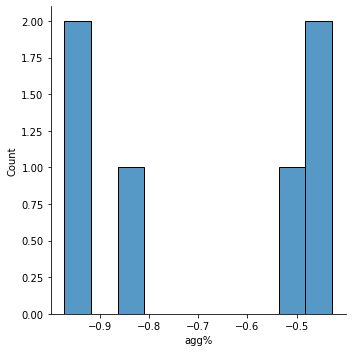

In [94]:
import seaborn as sns
sns.displot(sdf, x='agg%', bins=10)

In [106]:
# selecting the 3 sampled transactions with highest ETH slippage
pd.set_option('display.max_colwidth', None)
sdf.loc[sdf['agg%'] < -0.8, df.columns.difference(['pre', 'post'])]

,%,address,agg%,agg_post_amount,agg_pre_amount,agg_slippage,block,position,post_amount,pre_amount,slippage,transfer_from,transfer_to,tx,tx_from,tx_to
97019,-8316.422033,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,-0.831642,282715924459379,23794565356691443,-23511849432232064,16175456,7,282715924459379,23794565356691443,-23511849432232064,0x41964c76af7695c943702d72a9664a61d1ab6628,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbc4dbfa3abf4e35db554890e66e5458d82b704131d18f1747637bddb069fde75,0xe0083a84eb9abc7c608db984a51a6b9bc381446d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d
169999,-9589.569816,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,-0.958957,339912670810227,32936075549923043,-32596162879112816,16177253,14,339912670810227,32936075549923043,-32596162879112816,0x8d23ac31eae6fbdc8547f11bca46fda7d27944f3,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x116c6b9008e3795837b374d75030b4cedf678fc9e61d1ac0ed15258f67809e03,0xbcd4af638af9dfa73f5e7fa65272657fa5538a70,0x7a250d5630b4cf539739df2c5dacb4c659f2488d
211050,-9724.841832,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,-0.972484,133389784417010,13105335338843884,-12971945554426874,16178559,3,133389784417010,13105335338843884,-12971945554426874,0x46d61f560812674af6cabf1c9430b5ec79025348,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7892474f697de219b928203e6c86d22531e1e9b3ea09986f328506fc39c63d0c,0x7d3f30352042dc141ec327deb12218b25a977cd7,0x7a250d5630b4cf539739df2c5dacb4c659f2488d


Note: slippage below 1% is no indicator for front or back run.

## III. Mempool Records

*skipped this analysis to pursue promising results of the first section*

In comparison, insights produced by a global network of mempool listeners can only enhance the understanding of MEV. ERC20 transfer logs proved more informative than expected. At first, they were only meant to support the filtering of traces.